# Dog Breed Convolutional Classificator with TensorFlow

## Подключение GoogleDrive (Для Google Colab)

In [3]:
from google.colab import drive
import shutil
import zipfile
import os
import pathlib
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt

tf.test.gpu_device_name()

'/device:GPU:0'

## Подключение GoogleDrive (Для Google Colab)

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка набора данных из GoogleDrive

In [5]:
zip_file_path = '/content/drive/MyDrive/Datasets/StanfordDogs.zip'
shutil.copy(zip_file_path, '/content/')

unzip_dir = '/content/StanfordDogs/'
with zipfile.ZipFile('/content/StanfordDogs.zip', 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(os.listdir(unzip_dir))

['annotations', 'images']


## Валидация данных

In [6]:
def check_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                filepath = os.path.join(root, file)
                try:
                    img_raw = tf.io.read_file(filepath)
                    img = tf.io.decode_image(img_raw, channels=3)
                    img_jpeg = tf.io.encode_jpeg(tf.cast(img, tf.uint8))
                except (tf.errors.InvalidArgumentError, ValueError) as e:
                    print(f'Ошибка с изображением {filepath}: {e}')
                    os.remove(filepath)  # Удаление проблемного изображения


check_images(unzip_dir)

## Построение модели

Модель будет дообучаться на модели EfficientNetB0, обученной на основе набора данных ImageNet.

In [7]:
base_model = keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.2)
])

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(120, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          30,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,408,347 (16.82 MB)

 Trainable params: 358,776 (1.37 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

На этапе компиляции используем стандартный оптимизатор `RMSprop`. Так как модель должна однозначно предсказывать несколько классов, используем функцию потерь `categorical_crossentropy`.

In [8]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

## Загрузка данных

In [9]:
train_dataset = keras.utils.image_dataset_from_directory(
    '/content/StanfordDogs/images/Images',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=1488,
    label_mode='categorical'
)
validation_dataset = keras.utils.image_dataset_from_directory(
    '/content/StanfordDogs/images/Images',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=1488,
    label_mode='categorical'
)
test_dataset = validation_dataset.take(50)
val_ds = validation_dataset.skip(50)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


## Обучение модели с выделением признаков

Создадим обратный вызов, чтобы автоматически остановить обучение и сохранить лучший вариант модели. Далее обучим модель на ранее подготовленных данных.

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/dogbreeds.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
		    patience=10
    )
]

history = model.fit(
    train_dataset,
    epochs=70,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 69s 106ms/step - accuracy: 0.3122 - loss: 2.9505 - val_accuracy: 0.7556 - val_loss: 0.7954
Epoch 2/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 74s 98ms/step - accuracy: 0.5967 - loss: 1.3997 - val_accuracy: 0.7748 - val_loss: 0.7123
Epoch 3/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.6348 - loss: 1.2638 - val_accuracy: 0.7847 - val_loss: 0.6891
Epoch 4/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 83s 99ms/step - accuracy: 0.6591 - loss: 1.1875 - val_accuracy: 0.7860 - val_loss: 0.6750
Epoch 5/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - accuracy: 0.6743 - loss: 1.1329 - val_accuracy: 0.7840 - val_loss: 0.6974
Epoch 6/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 83s 98ms/step - accuracy: 0.6833 - loss: 1.1206 - val_accuracy: 0.7935 - val_loss: 0.6986
Epoch 7/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 82s 98ms/step - accuracy: 0.6941 - loss: 1.0747 - val_accuracy: 0.7937 - val_loss: 0.7012
Epoch 8/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 82s 98ms/step - accuracy: 0.6987 - loss: 1.0605 -

## Визуализация обучения с выделением признаков

Построим графики изменения потерь и точности в процессе обучения модели.

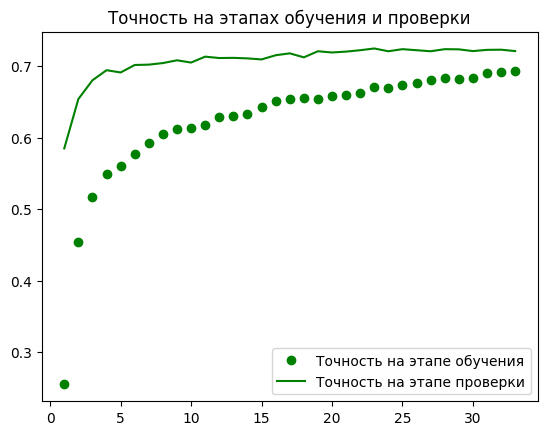

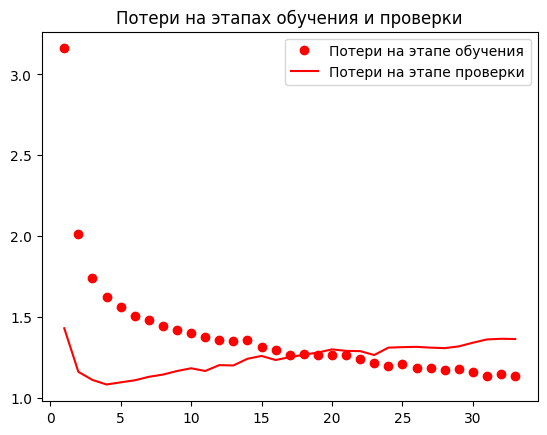

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'go', label='Точность на этапе обучения')
plt.plot(epochs, val_accuracy, 'g', label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.legend()
plt.show()

## Тестирование модели

In [ ]:
test_model = keras.models.load_model('/content/drive/dogbreeds.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')